In [8]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path, PurePath

In [27]:
def plot_logs(logs, fields=('class_error', 'loss_bbox_unscaled', 'mAP'), ewm_col=0, log_name='log.txt'):
    '''
    Function to plot specific fields from training log(s). Plots both training and test results.

    :: Inputs - logs = list containing Path objects, each pointing to individual dir with a log file
              - fields = which results to plot from each log file - plots both training and test for each field.
              - ewm_col = optional, which column to use as the exponential weighted smoothing of the plots
              - log_name = optional, name of log file if different than default 'log.txt'.

    :: Outputs - matplotlib plots of results in fields, color coded for each log file.
               - solid lines are training results, dashed lines are test results.

    '''
    func_name = "plot_utils.py::plot_logs"

    # verify logs is a list of Paths (list[Paths]) or single Pathlib object Path,
    # convert single Path to list to avoid 'not iterable' error

    if not isinstance(logs, list):
        if isinstance(logs, PurePath):
            logs = [logs]
            print(f"{func_name} info: logs param expects a list argument, converted to list[Path].")
        else:
            raise ValueError(f"{func_name} - invalid argument for logs parameter.\n \
            Expect list[Path] or single Path obj, received {type(logs)}")

    # Quality checks - verify valid dir(s), that every item in list is Path object, and that log_name exists in each dir
    for i, dir in enumerate(logs):
        if not isinstance(dir, PurePath):
            raise ValueError(f"{func_name} - non-Path object in logs argument of {type(dir)}: \n{dir}")
        if not dir.exists():
            raise ValueError(f"{func_name} - invalid directory in logs argument:\n{dir}")
        # verify log_name exists
        fn = Path(dir / log_name)
        if not fn.exists():
            print(f"-> missing {log_name}.  Have you gotten to Epoch 1 in training?")
            print(f"--> full path of missing log file: {fn}")
            return

    # load log file(s) and plot
    dfs = [pd.read_json(Path(p) / log_name, lines=True) for p in logs]

    fig, axs = plt.subplots(ncols=len(fields), figsize=(16, 5))

    for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
        for j, field in enumerate(fields):
            if field == 'mAP':
                coco_eval = pd.DataFrame(
                    np.stack(df.test_coco_eval_bbox.dropna().values)[:, 1]
                ).ewm(com=ewm_col).mean()
                axs[j].plot(coco_eval, c=color)
            else:
                df.interpolate().ewm(com=ewm_col).mean().plot(
                    y=[f'train_{field}', f'test_{field}'],
                    ax=axs[j],
                    color=[color] * 2,
                    style=['-', '--']
                )
    for ax, field in zip(axs, fields):
        ax.legend([Path(p).name for p in logs])
        ax.set_title(field)


def plot_precision_recall(files, naming_scheme='iter'):
    if naming_scheme == 'exp_id':
        # name becomes exp_id
        names = [f.parts[-3] for f in files]
    elif naming_scheme == 'iter':
        names = [f.stem for f in files]
    else:
        raise ValueError(f'not supported {naming_scheme}')
    fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
    for f, color, name in zip(files, sns.color_palette("Blues", n_colors=len(files)), names):
        data = torch.load(f)
        # precision is n_iou, n_points, n_cat, n_area, max_det
        precision = data['precision']
        recall = data['params'].recThrs
        scores = data['scores']
        # take precision for all classes, all areas and 100 detections
        precision = precision[0, :, :, 0, -1].mean(1)
        scores = scores[0, :, :, 0, -1].mean(1)
        prec = precision.mean()
        rec = data['recall'][0, :, 0, -1].mean()
        print(f'{naming_scheme} {name}: mAP@50={prec * 100: 05.1f}, ' +
              f'score={scores.mean():0.3f}, ' +
              f'f1={2 * prec * rec / (prec + rec + 1e-8):0.3f}'
              )
        axs[0].plot(recall, precision, c=color)
        axs[1].plot(recall, scores, c=color)

    axs[0].set_title('Precision / Recall')
    axs[0].legend(names)
    axs[1].set_title('Scores / Recall')
    axs[1].legend(names)
    return fig, axs

In [28]:
a = Path('logs/original') 
b = Path('logs/buggy')
c = Path('logs/fix_na_bug')
logs = [a,b,c]

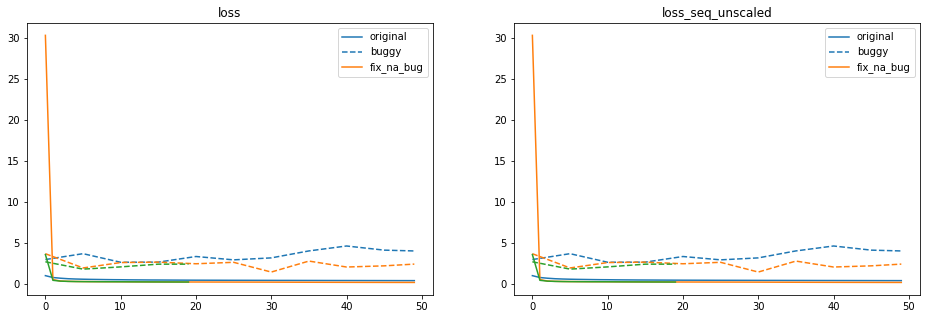

In [30]:
plot_logs(logs, fields=('loss', 'loss_seq_unscaled'), ewm_col=0, log_name='log.txt')

In [54]:
dfs = [pd.read_json(Path(p) / 'log.txt', lines=True) for p in logs]

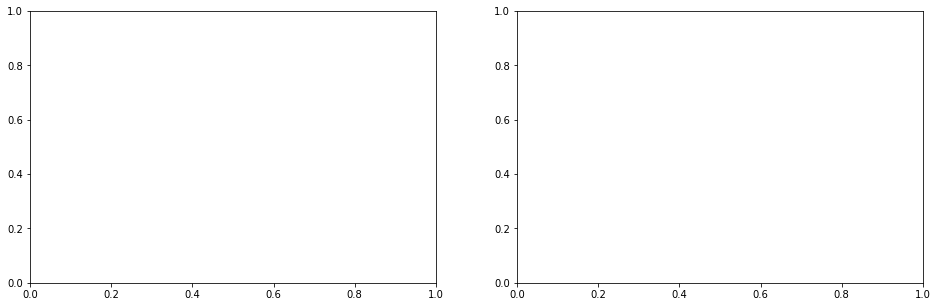

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

In [56]:
for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
    field = 'loss'
    df.interpolate().ewm(com=0).mean().plot(
        y=[f'train_{field}', f'test_{field}'],
        ax=axs[0],
        color=[color] * 2,
        style=['-', '--']
    )

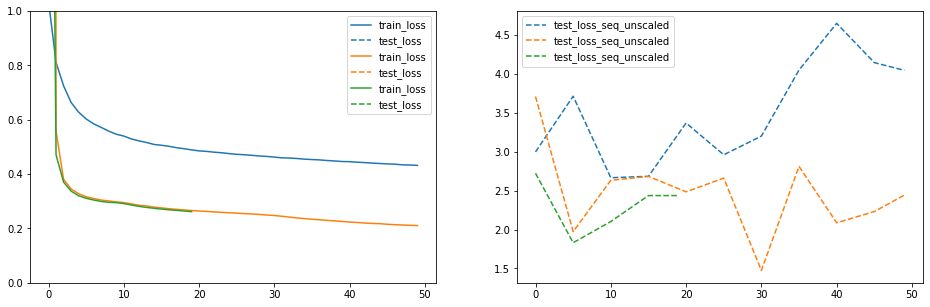

In [62]:
fig

In [59]:
for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
    field = 'loss_seq_unscaled'
    df.interpolate().ewm(com=0).mean().plot(
        y=[f'test_{field}'],
        ax=axs[1],
        color=[color] * 2,
        style=['--']
    )

In [61]:
axs[0].set_ylim([0.0, 1.0])

(0.0, 1.0)